In [3]:
import sys
import argparse



from tqdm import tqdm, trange
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToPILImage, Resize, ToTensor, Normalize, Compose

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np



from preprocess import preprocess_brats2020
from dataset import PN_BraTS2020_Dataset, PU_BraTS2020_Dataset, BCE_BraTS2020_Dataset
from model import unet
from nnPULoss import PULoss
from trainer import Trainer
%matplotlib inline
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
train_data, valid_data = preprocess_brats2020(root_dir='MICCAI_BraTS2020_TrainingData/', ratio_train_valid= 0.8, ratio_P_to_U= 0.95)


Preprocessing
	Step 1.	Get subject folder path from the root
	Step 2.	Split data for train and valid dataset
		Total:	369
		Ratio:	0.8
		#train:	295
		#valid:	74 
	Step 3.	Get img mode from all subject/folder
	Step 4.	Get which slice is unhealthy
	Step 5.	Slice 3D to 2D in prevision of torch.Dataset



In [6]:
from run_train import select_dataloader
print(len(train_data[0]), len(valid_data[0]))

t_data, v_data = (train_data[0][:16], train_data[1]) , (valid_data[0][:16], valid_data[1])

print(len(t_data[0]), len(v_data[0]))
train_dataloader, valid_dataloader,_ = select_dataloader(train_data, valid_data, "nnPU", 8, is_validation= True, num_worker= 8)

19876 4768
16 16
IMG status: torch.Size([1, 240, 240]) torch.float32 torch.FloatTensor
SEG status: torch.Size([240, 240]) torch.float32 torch.FloatTensor


In [7]:
data = next(iter(valid_dataloader))

In [ ]:
# print(np.unique(data['target'][0]))
# print(np.count_nonzero(data['target'][0]==0), np.count_nonzero(data['target'][0]==1), data['target'][0].size())
# plt.hist(data['target'][0])

In [ ]:
# # print(np.unique(data['img'][0]))
# print(np.count_nonzero(data['img'][0]==0), np.count_nonzero(data['img'][0]!=0), data['img'][0].size())
# plt.hist(data['img'][0].squeeze())

In [8]:
model = unet()
model.load_state_dict(torch.load('model_saved_BCELoss_NumWorker4/epoch_82',map_location=torch.device('cpu')))
output = model(data['img'])
# loss   = nn.BCEWithLogitsLoss()(output.squeeze(), data['target'].squeeze())

/storage/homefs/cp14h011/.conda/envs/unet/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


951


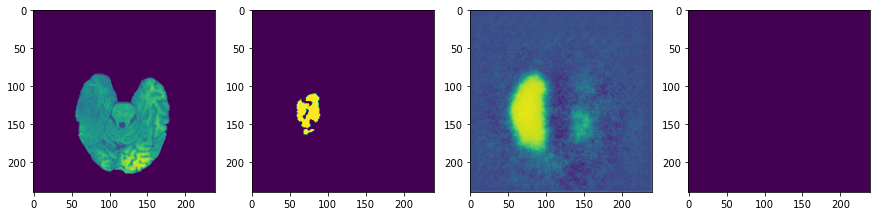

In [10]:
id = 6
f, arr = plt.subplots(1,4, figsize=(15,15))
arr[0].imshow(data['img'][id].squeeze())
arr[1].imshow(data['target'][id].squeeze())
arr[2].imshow(output.detach().numpy().squeeze()[id])
arr[3].imshow(torch.where(output>0.5, 1,0).detach().numpy().squeeze()[id])
print(np.count_nonzero(output[id]>0))

951


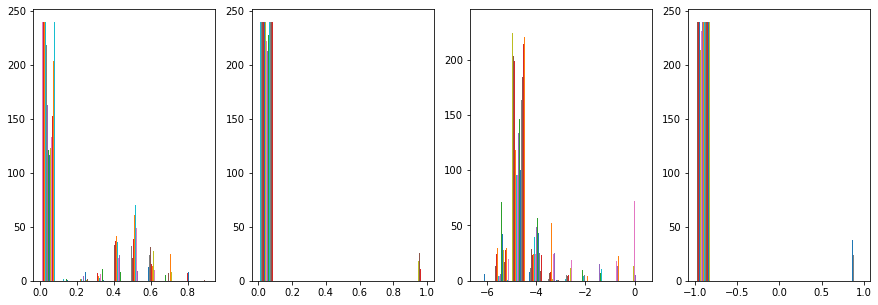

In [11]:
f, arr = plt.subplots(1,4, figsize=(15,5))
arr[0].hist(data['img'][id].squeeze())
arr[1].hist(data['target'][id].squeeze())
arr[2].hist(output.detach().numpy().squeeze()[id])
arr[3].hist(torch.sign(output).detach().numpy().squeeze()[id])
print(np.count_nonzero(output[id]>0))